In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import toml
import glob
import pandas as pd
import seaborn as sns
import czifile
import joblib
from qd_analysis.fig import setup_plotting_env
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm
from skimage.filters import threshold_otsu
from skimage.measure import regionprops_table
from cellpose import models
from skimage.exposure import rescale_intensity
from lxml import etree

## User functions

In [3]:
# Scale channels to 0–255 using percentiles for robustness
def scale_to_uint8(channel, pmin=1, pmax=95.):
    vmin, vmax = np.percentile(channel, (pmin, pmax))
    scaled = rescale_intensity(channel, in_range=(vmin, vmax), out_range=(0, 255))
    return scaled.astype(np.uint8)

In [4]:
def scale_im(im, channel_mapping=[1, 0, 2], pmin_red=20, pmin_all=20, pmax_red=95, pmax_all=99):
    composite = np.zeros((im.shape[1], im.shape[2], 3), dtype="uint8")
    for i, _ch in enumerate(channel_mapping):
        if i == 0:
            # red is a little dimmer
            pmin = pmin_all
            pmax = pmax_red
        else:
            pmin = pmin_all
            pmax = pmax_all
        composite[..., i] = scale_to_uint8(im[_ch], pmin, pmax)
    return composite

In [5]:
config = toml.load("../preprocessing/config.toml")

In [6]:
data_dirs = [
    os.path.join(config["dirs"]["data"], "histology_round2_wpa-and-dapi"),
]

fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [7]:
data_files = []
for _dir in data_dirs:
    data_files += sorted(glob.glob(os.path.join(_dir, "*20X.czi")))

In [8]:
slide_summary = pd.read_excel(os.path.join(data_dirs[0], "histology_round2_summary.xlsx"))

In [9]:
store_dat = {}
for _file in tqdm(data_files):
    key = os.path.splitext(os.path.basename(_file))[0]
    with czifile.CziFile(_file) as f:
        store_dat[(key,_file)] = f.asarray().squeeze()

  0%|          | 0/17 [00:00<?, ?it/s]

In [10]:
with czifile.CziFile(data_files[0]) as f:
    metadata_xml = f.metadata()
czi_parsed = etree.fromstring(metadata_xml)
root = czi_parsed.getroottree()
channels_xml = root.findall(".//Dimensions/Channels")[0].getchildren()

In [11]:
im_size = root.findall(".//Scaling")

In [12]:
if czi_parsed.tag.startswith('{'):
    ns_uri = czi_parsed.tag.split('}')[0].strip('{')
    ns = {'ns': ns_uri}
    prefix = 'ns:'
else:
    ns = None
    prefix = ''

In [13]:
distances = {}
for axis in ['X', 'Y', 'Z']:
    xpath = f".//{prefix}Distance[@Id='{axis}']"
    element = root.find(xpath, namespaces=ns)
    if element is not None:
        value_m = float(element.getchildren()[0].text)
        # value_m = float(element.get('Value'))
        distances[axis] = value_m * 1e6  # meters → microns
    else:
        distances[axis] = None

In [14]:
channels = [_.values() for _ in channels_xml]

In [15]:
composites = {}
for k, v in store_dat.items():
    composites[k] = scale_im(v)

In [16]:
# TODO: scale bar...get it from metadata

In [17]:
height, width = list(store_dat.values())[0].shape[1:]

In [18]:
# scale bar µm = 100
scale_bar_x = 50
scale_bar_offset = (50, height - 50)
scale_bar_x_pixels = scale_bar_x * (1 / distances["X"])
median_footprint = 5

In [19]:
for (k, _file), v in tqdm(composites.items()):
    fname = f"cell_vs_vasc_{k}_scale-{scale_bar_x}-um"

    if os.path.exists(os.path.join(fig_dir, f"{fname}.pdf")):
        continue

    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    use_v = v.copy()
    for i in range(v.ndim):
        # use_v[...,i] = median(use_v[...,i], disk(median_footprint))
        use_v[..., i] = cv2.medianBlur(use_v[..., i], median_footprint)
    for i, _ax in enumerate(ax):
        if i < 3:
            plt_v = np.zeros_like(use_v)
            plt_v[..., i] = use_v[..., i]
        else:
            plt_v = use_v
        _ax.imshow(plt_v)
        _ax.plot(
            [scale_bar_offset[0], scale_bar_offset[0] + scale_bar_x_pixels],
            [scale_bar_offset[1], scale_bar_offset[1]],
            "-",
            color="w",
            lw=3,
        )
        _ax.axis("off")
    fig.suptitle(k, y=0.85)
    fig.subplots_adjust(wspace=0.05)
    fig.savefig(os.path.join(fig_dir, f"{fname}.pdf"), dpi=1200, bbox_inches="tight")
    fig.savefig(os.path.join(fig_dir, f"{fname}.png"), dpi=1200, bbox_inches="tight")
    # break

  0%|          | 0/17 [00:00<?, ?it/s]

In [20]:
channel_mapping = [1, 0, 2]

In [21]:
dapi = [i for i, _tup in enumerate(channels) if "dapi" in _tup[1].lower()][0]
wga = [i for i, _tup in enumerate(channels) if "af488" in _tup[1].lower()][0]
qdot = [i for i, _tup in enumerate(channels) if "qd800" in _tup[1].lower()][0]

In [22]:
window_size = (400, 400)

In [23]:
test_im = list(store_dat.values())[-2]

In [24]:
model = models.Cellpose(model_type='cyto2', gpu=False)

In [25]:
results = []
for (k, _file), v in tqdm(store_dat.items(), total=len(store_dat)):
    thresh_dapi = threshold_otsu(v[dapi])
    thresh_wga = threshold_otsu(v[wga])
    thresh_qdot = threshold_otsu(v[qdot])
    use_dir = os.path.dirname(_file)
    save_file = os.path.join(use_dir, f"{k}.pkl")

    # need to save these, load from file if we already did it...
    if not os.path.exists(save_file):
        masks, _, _, _ = model.eval(
            v,
            diameter=None,  # automatic size estimation
            channels=[wga, dapi],  # [cytoplasm, nucleus], 0 means grayscale
            channel_axis=0,
            flow_threshold=0.4,
            cellprob_threshold=0.0,
        )
        joblib.dump({"masks": masks}, save_file)
    else:
        masks = joblib.load(save_file)["masks"]

    qdot_im = v[qdot]
    wga_im = v[wga]
    dapi_im = v[dapi]
    qdot_im_norm = (qdot_im - qdot_im.min()) / (qdot_im.max() - qdot_im.min())
    qdot_mask = qdot_im > thresh_qdot
    dapi_mask = dapi_im > thresh_dapi
    wga_mask = wga_im > thresh_wga

    cell_mask = masks > 0

    percell_qdot_fluo = regionprops_table(masks, intensity_image=qdot_im, properties=["mean_intensity"])[
        "mean_intensity"
    ]
    percell_qdot_fluo_norm = regionprops_table(masks, intensity_image=qdot_im_norm, properties=["mean_intensity"])[
        "mean_intensity"
    ]
    percell_qdot_mask = regionprops_table(
        masks, intensity_image=qdot_mask.astype("float"), properties=["mean_intensity"]
    )["mean_intensity"]
    total_area = qdot_mask.sum() / qdot_mask.size

    qdot_in_wga = qdot_im[wga_mask].sum()
    qdot_in_dapi = qdot_im[dapi_mask].sum()
    qdot_total = qdot_im.sum()

    fraction_qdot_in_wga = qdot_in_wga / qdot_total
    fraction_wga_area = wga_mask.sum() / wga_mask.size
    enrichment_wga = fraction_qdot_in_wga / fraction_wga_area

    fraction_qdot_in_dapi = qdot_in_dapi / qdot_total
    fraction_dapi_area = dapi_mask.sum() / dapi_mask.size
    enrichment_dapi = fraction_qdot_in_dapi / fraction_dapi_area

    # get correlations, masked and unmasked (cell v noncell?)

    rois = np.arange(len(percell_qdot_fluo))
    new_df = pd.DataFrame()
    new_df["qdot_fluo"] = percell_qdot_fluo
    new_df["qdot_fluo_norm"] = percell_qdot_fluo_norm
    new_df["roi"] = rois
    new_df["qdot_mean_noncell_fluo"] = qdot_im[masks <= 0].mean()
    new_df["qdot_mean_noncell_fluo_norm"] = qdot_im_norm[masks <= 0].mean()
    new_df["qdot_mean_cell_fluo_norm"] = qdot_im_norm[masks > 0].mean()
    new_df["filename"] = k
    new_df["filename_fig"] = f"cell_vs_vasc_{k}_scale-{scale_bar_x}-um"
    # new_df["filename"] = os.path.splitext(os.path.basename(_file))[0]
    results.append(new_df)
    # now with masks, we can get regionprops!

  0%|          | 0/17 [00:00<?, ?it/s]

In [26]:
result_df = pd.concat(results, ignore_index=True)
result_df["qdot_type"] = result_df["filename"].str.contains("cell")
result_df["qdot_type"] = result_df["qdot_type"].map({True: "cell_labeling", False: "vascular"})
result_df["qdot_fluo_norm_ratio"] = result_df["qdot_fluo_norm"] / result_df["qdot_mean_noncell_fluo_norm"]
result_df = pd.merge(result_df, slide_summary, left_on="filename_fig", right_on="filename", suffixes=(None,"_slide_summary"))

In [27]:
colors = {
    "cell_labeling": sns.color_palette("tab10")[1],
    "collagen_ab": sns.color_palette("bright")[3],
    "vascular": sns.color_palette("tab10")[0],
}

In [28]:
# use_df = result_df.query("qdot_total_area<inf")

In [29]:
setup_plotting_env()

In [30]:
result_df["group"] = result_df.groupby("injection")["group"].transform(lambda x: x.astype("category").cat.codes)

In [31]:
result_df["distance um relative"] = result_df.groupby(["injection","group"])["distance um"].transform(lambda x: x - x.min())
result_df["slice relative"] = result_df.groupby(["injection","group"])["total slice number"].transform(lambda x: x - x.min())
result_df["qdot_type"] = result_df["qdot_type"].astype("category")
result_df["qdot_type"] = result_df["qdot_type"].cat.set_categories(["vascular","cell_labeling"], ordered=True)

In [32]:
combined_keys = result_df[["group","slice relative"]].apply(tuple, axis=1)
# Factorize the combined keys to get numerical group IDs
group_ids, unique_combinations = pd.factorize(combined_keys)
result_df["group_id"] = group_ids
result_df["slice relative cat"] = result_df.groupby("injection")["group_id"].transform(lambda x: pd.factorize(x)[0])

In [33]:
divisor = 6
offset = result_df["slice relative cat"].mean() / divisor
center_points = result_df["qdot_type"].cat.codes.astype("float") * 1.5

result_df["x_scaled"] = center_points + (result_df["slice relative cat"] / divisor - offset)
label_points = sorted(center_points.unique())

cmap = plt.colormaps["turbo"]
kwargs = {"levels": result_df["slice relative cat"],
          "cmap": cmap}

n_categories = result_df["slice relative cat"].nunique()

cmap = plt.matplotlib.colors.ListedColormap(sns.color_palette("turbo",n_colors=n_categories))
norm = plt.matplotlib.colors.BoundaryNorm(boundaries=np.arange(-0.5, n_categories + 0.5, 1), ncolors=n_categories)

scatter_kwargs = {
    # "style":"group",
    "legend":False,
    "hue": "qdot_type",
    "palette": colors,
    # "markers":["o", "D"],  # Optional: explicitly set marker shapes
    "s":30,  # Optional: increase marker size
    "alpha":1.0,
    "cmap":cmap,
    "norm":norm,
    "clip_on":False,
}

/storage/home/hcoda1/4/jmarkowitz30/.local/lib/python3.10/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


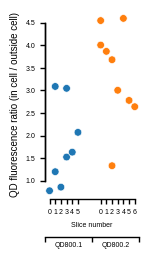

In [35]:
fig, ax = plt.subplots(1, figsize=(1.5, 2.4))
plt_data = (
    result_df.groupby(["qdot_type", "filename", "distance um relative", "slice relative cat", "group"], observed=True)[
        ["x_scaled", "qdot_fluo_norm_ratio"]
    ]
    .median()
    .reset_index()
).dropna()
xticks = plt_data[["x_scaled","slice relative cat"]].drop_duplicates()
sns.scatterplot(
    data=plt_data,
    x="x_scaled",
    y="qdot_fluo_norm_ratio",
    # c=plt_data["slice relative cat"],
    ax=ax,
    **scatter_kwargs,
)
ax.set_xlabel("Slice number", fontsize=5)
ax.set_xticks(xticks["x_scaled"], xticks["slice relative cat"])
fig.tight_layout()

ax.set_ylabel("QD fluorescence ratio (in cell / outside cell)")
ax2 = ax.twiny()
ax2.spines["bottom"].set_position(("axes", -0.20))
ax2.tick_params("both", length=0, width=0, which="minor")
ax2.tick_params("both", direction="out", which="major")
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

xlims = ax.get_xlim()
major_ticks = [xlims[0], (xlims[0] + xlims[1]) / 2.0, xlims[1]]
ax2.set_xticks(major_ticks)
ax2.xaxis.set_major_formatter(plt.matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(
    plt.matplotlib.ticker.FixedLocator(((major_ticks[0] + major_ticks[1]) / 2, (major_ticks[1] + major_ticks[2]) / 2))
)
ax2.xaxis.set_minor_formatter(plt.matplotlib.ticker.FixedFormatter(["QD800.1", "QD800.2"]))
sns.despine(trim=True)

# sm = plt.matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Required for ScalarMappable with colorbar

# cbar = plt.colorbar(sm, ticks=np.arange(n_categories), ax=ax, pad=0.15, shrink=0.6)
# cbar.set_label("Slice no.")
# cbar.ax.tick_params(which="minor", length=0)
# cbar.ax.minorticks_off()

fig.savefig(os.path.join(fig_dir, "histology_cell_vs_vasc_cell-noncell-ratio.pdf"), bbox_inches="tight", dpi=600)

In [36]:
group1 = result_df.groupby(["qdot_type", "filename"])["qdot_fluo_norm_ratio"].median().loc["cell_labeling"]
group2 = result_df.groupby(["qdot_type", "filename"])["qdot_fluo_norm_ratio"].median().loc["vascular"]

stat = mannwhitneyu(group1, group2)

n1 = len(group1)
n2 = len(group2)

f = stat.statistic / (n1 * n2)

stat_dct = {}
stat_dct["cell_vs_vasc"] = {}
stat_dct["cell_vs_vasc"]["p"] = stat.pvalue
stat_dct["cell_vs_vasc"]["statistic"] = stat.statistic
stat_dct["cell_vs_vasc"]["f"] = f
stat_dct["cell_vs_vasc"]["n(cell_labeling)"] = n1
stat_dct["cell_vs_vasc"]["n(vascular)"] = n2
stat_dct["cell_vs_vasc"]["cell_labeling_stats"] = group1.describe()
stat_dct["cell_vs_vasc"]["vascular_stats"] = group2.describe()
stat_dct["cell_vs_vasc"]["test"] = mannwhitneyu.__name__

/tmp/ipykernel_1348869/234885922.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group1 = result_df.groupby(["qdot_type", "filename"])["qdot_fluo_norm_ratio"].median().loc["cell_labeling"]
/tmp/ipykernel_1348869/234885922.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group2 = result_df.groupby(["qdot_type", "filename"])["qdot_fluo_norm_ratio"].median().loc["vascular"]


In [37]:
with open(os.path.join(fig_dir, "histology_cell_vs_vasc_cell-noncell-ratio.toml"), "w") as f:
    toml.dump(stat_dct, f)

# Analyze Collagen co-localization

In [38]:
data_dir = os.path.join(config["dirs"]["data"], "histology_round2_collagen-and-dapi")
data_files = sorted(glob.glob(os.path.join(data_dir, "*63X.czi")))
# data_files = [_file for _file in data_files if "BF" not in _file]

In [39]:
store_dat = {}
for _file in tqdm(data_files):
    key = os.path.splitext(os.path.basename(_file))[0]
    with czifile.CziFile(_file) as f:
        store_dat[(key,_file)] = f.asarray().squeeze()

  0%|          | 0/23 [00:00<?, ?it/s]

In [40]:
with czifile.CziFile(data_files[0]) as f:
    metadata_xml = f.metadata()
czi_parsed = etree.fromstring(metadata_xml)
root = czi_parsed.getroottree()
channels_xml = root.findall(".//Dimensions/Channels")[0].getchildren()

In [41]:
distances = {}
for axis in ['X', 'Y', 'Z']:
    xpath = f".//{prefix}Distance[@Id='{axis}']"
    element = root.find(xpath, namespaces=ns)
    if element is not None:
        value_m = float(element.getchildren()[0].text)
        # value_m = float(element.get('Value'))
        distances[axis] = value_m * 1e6  # meters → microns
    else:
        distances[axis] = None

In [42]:
channels = [_.values() for _ in channels_xml]

In [43]:
composites = {}
for k, v in tqdm(store_dat.items()):
    # composites[k] = scale_im(v, pmin_red=40, pmin_all=30, pmax_red=90, pmax_all=95)
    composites[k] = scale_im(v)

  0%|          | 0/23 [00:00<?, ?it/s]

In [44]:
height, width = list(store_dat.values())[0].shape[1:]

In [45]:
scale_bar_x = 10
scale_bar_offset = (50, height - 50)
scale_bar_x_pixels = scale_bar_x * (1 / distances["X"])

In [46]:
median_footprint = 5

In [47]:
for (k, _file), v in tqdm(composites.items()):
    fname = f"coll-ab_vs_vasc_{k}_scale-{scale_bar_x}-um"
    if os.path.exists(os.path.join(fig_dir, f"{fname}.pdf")):
        continue

    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    use_v = v.copy()
    for i in range(v.ndim):
        # use_v[...,i] = median(use_v[i], disk(median_footprint))
        use_v[..., i] = cv2.medianBlur(use_v[..., i], median_footprint)
    for i, _ax in enumerate(ax):
        if i < 3:
            plt_v = np.zeros_like(use_v)
            plt_v[..., i] = use_v[..., i]
        else:
            plt_v = use_v
        _ax.imshow(plt_v)
        _ax.plot(
            [scale_bar_offset[0], scale_bar_offset[0] + scale_bar_x_pixels],
            [scale_bar_offset[1], scale_bar_offset[1]],
            "-",
            color="w",
            lw=3,
        )
        _ax.axis("off")
    fig.suptitle(k, y=0.85)
    fig.subplots_adjust(wspace=0.05)
    fig.savefig(os.path.join(fig_dir, f"{fname}.pdf"), dpi=1200, bbox_inches="tight")
    fig.savefig(os.path.join(fig_dir, f"{fname}.png"), dpi=1200, bbox_inches="tight")
    # break

  0%|          | 0/23 [00:00<?, ?it/s]

In [48]:
channel_mapping = [1, 0, 2]

In [49]:
dapi = [i for i, _tup in enumerate(channels) if "dapi" in _tup[1].lower()][0]
coll = [i for i, _tup in enumerate(channels) if "af488" in _tup[1].lower()][0]
qdot = [i for i, _tup in enumerate(channels) if "qd800" in _tup[1].lower()][0]

In [50]:
results = []
for (k, _file), v in store_dat.items():
    qdot_im = v[qdot]
    coll_im = v[coll]
    dapi_im = v[dapi]

    # Threshold to create masks
    thresh_qdot = threshold_otsu(qdot_im)
    qdot_mask = qdot_im > thresh_qdot

    qdot_im_norm = (qdot_im - qdot_im.min()) / (qdot_im.max() - qdot_im.min())
    thresh_coll = threshold_otsu(coll_im)
    coll_mask = coll_im > thresh_coll

    thresh_dapi = threshold_otsu(coll_im)
    dapi_mask = dapi_im > thresh_dapi
    total_area = qdot_mask.sum() / qdot_mask.size

    results.append(
        {
            "filename": k,
            "filename_fig": f"coll-ab_vs_vasc_{k}_scale-{scale_bar_x}-um",
            "collagen_qdot_fluo_norm": qdot_im_norm[coll_mask].mean(),
            "collagen_qdot_fluo": qdot_im[coll_mask].mean(),
            "dapi_qdot_fluo_norm": qdot_im_norm[dapi_mask].mean(),
            "dapi_qdot_fluo": qdot_im[dapi_mask].mean(),
            "total_area": total_area,
            
        }
    )

In [51]:
result_df = pd.DataFrame(results)

In [52]:
result_df["qdot_type"] = ~result_df["filename"].str.contains("vasc")
result_df["qdot_type"] = result_df["qdot_type"].map({True: "collagen_ab", False: "vascular"})
result_df["collagen_qdot_fluo_norm_ratio"] = result_df["collagen_qdot_fluo_norm"] / result_df["dapi_qdot_fluo_norm"]
result_df = pd.merge(result_df, slide_summary, left_on="filename_fig", right_on="filename", suffixes=(None,"_slide_summary"))

In [53]:
result_df["group"] = result_df.groupby("injection")["group"].transform(lambda x: x.astype("category").cat.codes)

In [54]:
result_df["distance um relative"] = result_df.groupby(["injection","group"])["distance um"].transform(lambda x: x - x.min())
result_df["slice relative"] = result_df.groupby(["injection","group"])["total slice number"].transform(lambda x: x - x.min())
result_df["qdot_type"] = result_df["qdot_type"].astype("category")
result_df["qdot_type"] = result_df["qdot_type"].cat.set_categories(["vascular","collagen_ab"], ordered=True)

In [55]:
combined_keys = result_df[["group","slice relative"]].apply(tuple, axis=1)
group_ids, unique_combinations = pd.factorize(combined_keys)
result_df["group_id"] = group_ids
result_df["slice relative cat"] = result_df.groupby("injection")["group_id"].transform(lambda x: pd.factorize(x)[0])

In [56]:
divisor = 6
offset = result_df["slice relative cat"].mean() / divisor
center_points = result_df["qdot_type"].cat.codes.astype("float") * 1.2

result_df["x_scaled"] = center_points + (result_df["slice relative cat"] / divisor - offset)
label_points = sorted(center_points.unique())

cmap = plt.colormaps["turbo"]
kwargs = {"levels": result_df["slice relative cat"],
          "cmap": cmap}

n_categories = result_df["slice relative cat"].nunique()

cmap = plt.matplotlib.colors.ListedColormap(sns.color_palette("turbo",n_colors=n_categories))
norm = plt.matplotlib.colors.BoundaryNorm(boundaries=np.arange(-0.5, n_categories + 0.5, 1), ncolors=n_categories)

scatter_kwargs = {
    # "style":"group",
    "legend":False,
    "hue": "qdot_type",
    "palette": colors,
    # "markers":["o", "D"],  # Optional: explicitly set marker shapes
    "s":30,  # Optional: increase marker size
    "alpha":1.0,
    "cmap":cmap,
    "norm":norm,
    "clip_on":False,
}

/storage/home/hcoda1/4/jmarkowitz30/.local/lib/python3.10/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


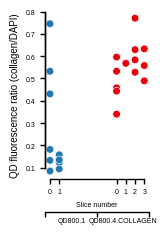

In [57]:
fig, ax = plt.subplots(1, figsize=(1.6, 2.2))
plt_data = (
    result_df.groupby(["qdot_type", "filename", "distance um relative", "slice relative cat", "group"], observed=True)[
        ["x_scaled", "collagen_qdot_fluo_norm_ratio"]
    ]
    .median()
    .reset_index()
).dropna()
xticks = plt_data[["x_scaled","slice relative cat"]].drop_duplicates()

sns.scatterplot(
    data=plt_data,
    x="x_scaled",
    y="collagen_qdot_fluo_norm_ratio",
    ax=ax,
    **scatter_kwargs,
)

ax.set_xlabel("Slice number", fontsize=5)
ax.set_xticks(xticks["x_scaled"], xticks["slice relative cat"])
fig.tight_layout()

ax.set_ylabel("QD fluorescence ratio (in cell / outside cell)")

ax2 = ax.twiny()
ax2.spines["bottom"].set_position(("axes", -0.20))
ax2.tick_params("both", length=0, width=0, which="minor")
ax2.tick_params("both", direction="out", which="major")
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

xlims = ax.get_xlim()
major_ticks = [xlims[0], (xlims[0] + xlims[1]) / 2.0, xlims[1]]
ax2.set_xticks(major_ticks)
ax2.xaxis.set_major_formatter(plt.matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(
    plt.matplotlib.ticker.FixedLocator(((major_ticks[0] + major_ticks[1]) / 2, (major_ticks[1] + major_ticks[2]) / 2))
)
ax2.xaxis.set_minor_formatter(plt.matplotlib.ticker.FixedFormatter(["QD800.1", "QD800.4.COLLAGEN"]))
sns.despine(trim=True)
ax.set_ylabel("QD fluorescence ratio (collagen/DAPI)")
fig.savefig(os.path.join(fig_dir, "histology_collagen_vs_vasc_fluo-ratio.pdf"), bbox_inches="tight", dpi=600)

In [59]:
group1 = result_df.groupby(["qdot_type", "filename"])["collagen_qdot_fluo_norm_ratio"].median().loc["collagen_ab"]
group2 = result_df.groupby(["qdot_type", "filename"])["collagen_qdot_fluo_norm_ratio"].median().loc["vascular"]

stat = mannwhitneyu(group1, group2)

n1 = len(group1)
n2 = len(group2)

f = stat.statistic / (n1 * n2)

stat_dct = {}
stat_dct["collagen-ab_vs_vasc"] = {}
stat_dct["collagen-ab_vs_vasc"]["p"] = stat.pvalue
stat_dct["collagen-ab_vs_vasc"]["statistic"] = stat.statistic
stat_dct["collagen-ab_vs_vasc"]["f"] = f
stat_dct["collagen-ab_vs_vasc"]["n(collagen_ab)"] = n1
stat_dct["collagen-ab_vs_vasc"]["n(vascular)"] = n2
stat_dct["collagen-ab_vs_vasc"]["collagen_ab_stats"] = group1.describe()
stat_dct["collagen-ab_vs_vasc"]["vascular_stats"] = group2.describe()
stat_dct["collagen-ab_vs_vasc"]["test"] = mannwhitneyu.__name__

/tmp/ipykernel_1348869/3897043956.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group1 = result_df.groupby(["qdot_type", "filename"])["collagen_qdot_fluo_norm_ratio"].median().loc["collagen_ab"]
/tmp/ipykernel_1348869/3897043956.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group2 = result_df.groupby(["qdot_type", "filename"])["collagen_qdot_fluo_norm_ratio"].median().loc["vascular"]


In [60]:
with open(os.path.join(fig_dir, "histology_collagen_vs_vasc_enrichment-ratio.toml"), "w") as f:
    toml.dump(stat_dct, f)